In [0]:
%matplotlib inline
%reload_ext autoreload
%autoreload 2

In [0]:
from fastai.conv_learner import *
from fastai.dataset import *
from fastai.models.resnet import vgg_resnet50

import json

In [0]:
torch.cuda.set_device(0)

In [0]:
torch.backends.cudnn.benchmark=True

## Data

In [0]:
PATH = Path('data/carvana')
MASKS_FN = 'train_masks.csv'
META_FN = 'metadata.csv'
masks_csv = pd.read_csv(PATH/MASKS_FN)
meta_csv = pd.read_csv(PATH/META_FN)

In [0]:
def show_img(im, figsize=None, ax=None, alpha=None):
    if not ax: fig,ax = plt.subplots(figsize=figsize)
    ax.imshow(im, alpha=alpha)
    ax.set_axis_off()
    return ax

In [0]:
TRAIN_DN = 'train-128'
MASKS_DN = 'train_masks-128'
sz = 128
bs = 64
nw = 16

In [0]:
TRAIN_DN = 'train'
MASKS_DN = 'train_masks_png'
sz = 128
bs = 64
nw = 16

In [0]:
class MatchedFilesDataset(FilesDataset):
    def __init__(self, fnames, y, transform, path):
        self.y=y
        assert(len(fnames)==len(y))
        super().__init__(fnames, transform, path)
    def get_y(self, i): return open_image(os.path.join(self.path, self.y[i]))
    def get_c(self): return 0

In [0]:
x_names = np.array([Path(TRAIN_DN)/o for o in masks_csv['img']])
y_names = np.array([Path(MASKS_DN)/f'{o[:-4]}_mask.png' for o in masks_csv['img']])

In [0]:
val_idxs = list(range(1008))
((val_x,trn_x),(val_y,trn_y)) = split_by_idx(val_idxs, x_names, y_names)

In [0]:
aug_tfms = [RandomRotate(4, tfm_y=TfmType.CLASS),
            RandomFlip(tfm_y=TfmType.CLASS),
            RandomLighting(0.05, 0.05, tfm_y=TfmType.CLASS)]

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [0]:
x,y = next(iter(md.trn_dl))

In [17]:
x.shape,y.shape

(torch.Size([64, 3, 128, 128]), torch.Size([64, 128, 128]))

## Simple upsample

In [0]:
f = resnet34
cut,lr_cut = model_meta[f]

In [0]:
def get_base():
    layers = cut_model(f(True), cut)
    return nn.Sequential(*layers)

In [0]:
def dice(pred, targs):
    pred = (pred>0).float()
    return 2. * (pred*targs).sum() / (pred+targs).sum()

In [0]:
class StdUpsample(nn.Module):
    def __init__(self, nin, nout):
        super().__init__()
        self.conv = nn.ConvTranspose2d(nin, nout, 2, stride=2)
        self.bn = nn.BatchNorm2d(nout)
        
    def forward(self, x): return self.bn(F.relu(self.conv(x)))

In [0]:
class Upsample34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.features = nn.Sequential(
            rn, nn.ReLU(),
            StdUpsample(512,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            StdUpsample(256,256),
            nn.ConvTranspose2d(256, 1, 2, stride=2))
        
    def forward(self,x): return self.features(x)[:,0]

In [0]:
class UpsampleModel():
    def __init__(self,model,name='upsample'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model.features)[1:]]

In [24]:
m_base = get_base()

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /root/.torch/models/resnet34-333f7ec4.pth
100%|██████████| 87306240/87306240 [00:01<00:00, 58912851.49it/s]


In [0]:
m = to_gpu(Upsample34(m_base))
models = UpsampleModel(m)

In [0]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [0]:
learn.freeze_to(1)

Widget Javascript not detected.  It may not be installed or enabled properly.


 86%|████████▌ | 55/64 [00:26<00:02,  3.19it/s, loss=2.55] 

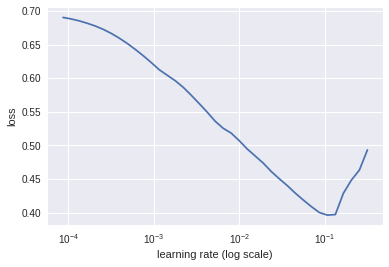

In [28]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=4e-2
wd=1e-7
lrs = np.array([lr/100,lr/10,lr])/2

In [30]:
learn.fit(lr,1, wds=wd, cycle_len=4,use_clr=(20,8))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.115931   0.056309   0.977657   0.945001  
    1      0.060174   0.04955    0.975689   0.946256  
    2      0.041546   0.034054   0.986305   0.966683  
    3      0.032989   0.029672   0.987986   0.97141   


[array([0.02967]), 0.9879858238356454, 0.9714104422234011]

In [0]:
learn.save('tmp')

In [0]:
learn.load('tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [34]:
learn.fit(lrs,1,cycle_len=4,use_clr=(20,8))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.030028   0.029207   0.986817   0.971187  
    1      0.026926   0.026925   0.98819    0.973638  
    2      0.024786   0.025503   0.989732   0.975597  
    3      0.023333   0.024525   0.989893   0.976522  


[array([0.02453]), 0.9898933531746031, 0.9765216121786243]

In [0]:
learn.save('128')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

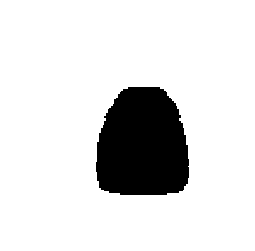

In [37]:
show_img(py[0]>0);

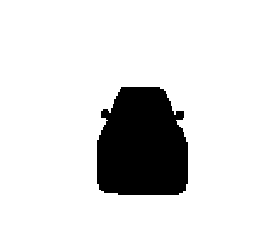

In [38]:
show_img(y[0]);

## U-net (ish)

In [0]:
class SaveFeatures():
    features=None
    def __init__(self, m): self.hook = m.register_forward_hook(self.hook_fn)
    def hook_fn(self, module, input, output): self.features = output
    def remove(self): self.hook.remove()

In [0]:
class UnetBlock(nn.Module):
    def __init__(self, up_in, x_in, n_out):
        super().__init__()
        up_out = x_out = n_out//2
        self.x_conv  = nn.Conv2d(x_in,  x_out,  1)
        self.tr_conv = nn.ConvTranspose2d(up_in, up_out, 2, stride=2)
        self.bn = nn.BatchNorm2d(n_out)
        
    def forward(self, up_p, x_p):
        up_p = self.tr_conv(up_p)
        x_p = self.x_conv(x_p)
        cat_p = torch.cat([up_p,x_p], dim=1)
        return self.bn(F.relu(cat_p))

In [0]:
class Unet34(nn.Module):
    def __init__(self, rn):
        super().__init__()
        self.rn = rn
        self.sfs = [SaveFeatures(rn[i]) for i in [2,4,5,6]]
        self.up1 = UnetBlock(512,256,256)
        self.up2 = UnetBlock(256,128,256)
        self.up3 = UnetBlock(256,64,256)
        self.up4 = UnetBlock(256,64,256)
        self.up5 = nn.ConvTranspose2d(256, 1, 2, stride=2)
        
    def forward(self,x):
        x = F.relu(self.rn(x))
        x = self.up1(x, self.sfs[3].features)
        x = self.up2(x, self.sfs[2].features)
        x = self.up3(x, self.sfs[1].features)
        x = self.up4(x, self.sfs[0].features)
        x = self.up5(x)
        return x[:,0]
    
    def close(self):
        for sf in self.sfs: sf.remove()

In [0]:
class UnetModel():
    def __init__(self,model,name='unet'):
        self.model,self.name = model,name

    def get_layer_groups(self, precompute):
        lgs = list(split_by_idxs(children(self.model.rn), [lr_cut]))
        return lgs + [children(self.model)[1:]]

In [0]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [0]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [45]:
learn.summary()

OrderedDict([('Conv2d-1',
              OrderedDict([('input_shape', [-1, 3, 128, 128]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 9408)])),
             ('BatchNorm2d-2',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('trainable', False),
                           ('nb_params', 128)])),
             ('ReLU-3',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 64, 64]),
                           ('nb_params', 0)])),
             ('MaxPool2d-4',
              OrderedDict([('input_shape', [-1, 64, 64, 64]),
                           ('output_shape', [-1, 64, 32, 32]),
                           ('nb_params', 0)])),
             ('Conv2d-5',
              OrderedDict([('input_shape', [-1, 64, 32, 32]),
      

In [46]:
[o.features.size() for o in m.sfs]

[torch.Size([3, 64, 64, 64]),
 torch.Size([3, 64, 32, 32]),
 torch.Size([3, 128, 16, 16]),
 torch.Size([3, 256, 8, 8])]

In [0]:
learn.freeze_to(1)

Widget Javascript not detected.  It may not be installed or enabled properly.


 91%|█████████ | 58/64 [00:25<00:01,  3.41it/s, loss=2.51] 

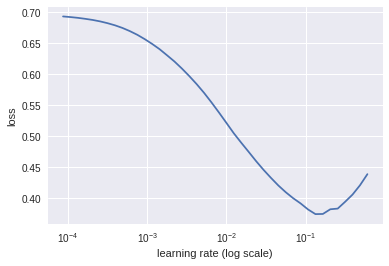

In [48]:
learn.lr_find()
learn.sched.plot()

In [0]:
lr=4e-2
wd=1e-7

lrs = np.array([lr/100,lr/10,lr])

In [50]:
learn.fit(lr,1,wds=wd,cycle_len=8,use_clr=(5,8))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.066519   0.047133   0.984611   0.958297  
    1      0.035288   0.027905   0.989773   0.973787  
    2      0.026709   0.022299   0.991288   0.978993  
    3      0.022755   0.022497   0.991269   0.978882  
    4      0.02126    0.020962   0.990906   0.979839  
    5      0.019729   0.019809   0.991937   0.981329  
    6      0.01846    0.018494   0.992563   0.982726  
    7      0.017525   0.018754   0.992917   0.982585  


[array([0.01875]), 0.9929165310329862, 0.9825850273035747]

In [0]:
learn.save('128urn-tmp')

In [0]:
learn.load('128urn-tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [57]:
learn.fit(lrs/4, 1, wds=wd, cycle_len=20,use_clr=(20,10))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.016167   0.0185     0.993043   0.982994  
    1      0.016272   0.018159   0.992136   0.982845  
    2      0.016172   0.018017   0.992022   0.982891  
    3      0.015704   0.025278   0.991877   0.977556  
    4      0.01526    0.016515   0.993587   0.984864  
    5      0.014844   0.016637   0.993679   0.984918  
    6      0.014572   0.016244   0.993558   0.985082  
    7      0.014239   0.016185   0.993528   0.985179  
    8      0.013917   0.015904   0.993775   0.985471  
    9      0.013726   0.016016   0.993663   0.985412  
    10     0.013541   0.0158     0.993866   0.985597  
    11     0.013484   0.015859   0.993806   0.985635  
    12     0.013342   0.015641   0.993829   0.985796  
    13     0.013184   0.015737   0.993812   0.985797  
    14     0.013085   0.015804   0.993667   0.985734  
    15     0.012911   0.015542   0.994064   0.986049  
    16     0.012735   0.015495   0.993987   0.986059  
    17   

[array([0.01538]), 0.9940671173353044, 0.9862302281194462]

In [0]:
learn.save('128urn-0')

In [0]:
learn.load('128urn-0')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

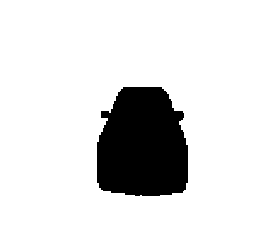

In [63]:
show_img(py[0]>0);

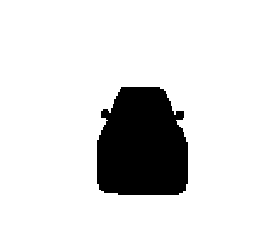

In [64]:
show_img(y[0]);

In [0]:
m.close()

## 512x512

In [0]:
sz=512
bs=16

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS, aug_tfms=aug_tfms)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=4, classes=None)
denorm = md.trn_ds.denorm

In [0]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [0]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [0]:
learn.freeze_to(1)

In [0]:
learn.load('128urn-0')

In [72]:
learn.fit(lr,1,wds=wd, cycle_len=5,use_clr=(5,5))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.017929   0.015458   0.993973   0.985869  
    1      0.015561   0.013833   0.994515   0.987363  
    2      0.013574   0.013538   0.994384   0.987583  
    3      0.01269    0.012046   0.995275   0.988829  
    4      0.011553   0.011678   0.995617   0.989124  


[array([0.01168]), 0.9956173707568456, 0.9891241536039175]

In [0]:
learn.save('512urn-tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [0]:
learn.load('512urn-tmp')

In [79]:
learn.fit(lrs/4,1,wds=wd, cycle_len=8,use_clr=(20,8))

Widget Javascript not detected.  It may not be installed or enabled properly.


epoch      trn_loss   val_loss   <lambda>   dice       
    0      0.011099   0.010917   0.995726   0.990099  
    1      0.010502   0.010703   0.995988   0.990233  
    2      0.009984   0.010462   0.996199   0.990515  
    3      0.009619   0.009924   0.995967   0.990911  
    4      0.009374   0.010091   0.996324   0.990902  
    5      0.008946   0.009653   0.996212   0.991256  
    6      0.008847   0.009579   0.996253   0.991366  
    7      0.008664   0.00936    0.996387   0.991521  


[array([0.00936]), 0.9963871524447486, 0.9915211846800412]

In [0]:
learn.save('512urn')

In [0]:
learn.load('512urn')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

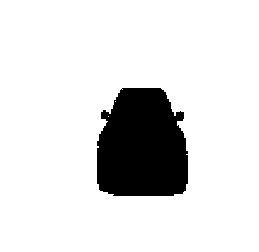

In [83]:
show_img(py[0]>0);

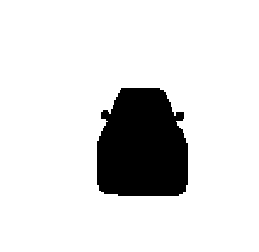

In [84]:
show_img(y[0]);

In [0]:
m.close()

## 1024x1024

In [0]:
sz=1024
bs=4

In [0]:
tfms = tfms_from_model(resnet34, sz, crop_type=CropType.NO, tfm_y=TfmType.CLASS)
datasets = ImageData.get_ds(MatchedFilesDataset, (trn_x,trn_y), (val_x,val_y), tfms, path=PATH)
md = ImageData(PATH, datasets, bs, num_workers=16, classes=None)
denorm = md.trn_ds.denorm

In [0]:
m_base = get_base()
m = to_gpu(Unet34(m_base))
models = UnetModel(m)

In [0]:
learn = ConvLearner(md, models)
learn.opt_fn=optim.Adam
learn.crit=nn.BCEWithLogitsLoss()
learn.metrics=[accuracy_thresh(0.5),dice]

In [0]:
learn.load('512urn')

In [0]:
learn.freeze_to(1)

In [0]:
learn.fit(lr,1, wds=wd, cycle_len=2,use_clr=(5,4))

Widget Javascript not detected.  It may not be installed or enabled properly.


  0%|          | 0/1020 [00:00<?, ?it/s]

In [0]:
learn.save('1024urn-tmp')

In [0]:
learn.load('1024urn-tmp')

In [0]:
learn.unfreeze()
learn.bn_freeze(True)

In [0]:
lrs = np.array([lr/200,lr/30,lr])

In [0]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.005688   0.006135   0.997616   0.994616  
    1      0.004412   0.005223   0.997983   0.995349             
    2      0.004186   0.004975   0.99806    0.99554              
    3      0.004016   0.004899   0.99812    0.995627             



[0.004898778487196458, 0.9981196409180051, 0.9956271404784823]

In [0]:
learn.fit(lrs/10,1, wds=wd,cycle_len=4,use_clr=(20,8))

epoch      trn_loss   val_loss   <lambda>   dice                 
    0      0.004169   0.004962   0.998049   0.995517  
    1      0.004022   0.004595   0.99823    0.995818             
    2      0.003772   0.004497   0.998215   0.995916             
    3      0.003618   0.004435   0.998291   0.995991             



[0.004434524739663753, 0.9982911745707194, 0.9959913929776539]

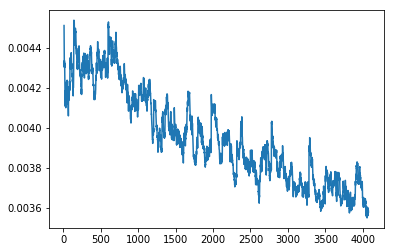

In [0]:
learn.sched.plot_loss()

In [0]:
learn.save('1024urn')

In [0]:
learn.load('1024urn')

In [0]:
x,y = next(iter(md.val_dl))
py = to_np(learn.model(V(x)))

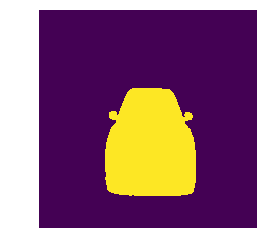

In [0]:
show_img(py[0]>0);

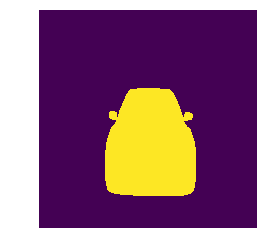

In [0]:
show_img(y[0]);